<a href="https://colab.research.google.com/github/lunaB/AI-Experiment/blob/master/gan_font__interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import pickle


# draw
def draw_single_char(ch, font, canvas_size):
    image = Image.new('L', (canvas_size, canvas_size), color=255)
    drawing = ImageDraw.Draw(image)
    w, h = drawing.textsize(ch, font=font)

    drawing.text(
        ((canvas_size-w)/2, (canvas_size-h)/2),
        ch,
        fill=(0),
        font=font
    )
    flag = np.sum(np.array(image))
    
    # 해당 font에 글자 없을시
    if flag == 255 * 128 * 128:
        return None

    if w>canvas_size or h>canvas_size:
        print('[warning] 사이즈를 맞춰주세요')

    return image

# ttf to pickle
def ttf_to_pkl(font_path, pkl_path, canvas_size=128, font_size=90):
    font = ImageFont.truetype(font=font_path, size=font_size)
    upper = "A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z"
    lower = "a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z"

    text = (upper+', '+lower).split(", ")

    text_img = []

    for i in text:
        img = draw_single_char(i, font, canvas_size)
        text_img.append(np.array(img))

    with open(pkl_path, 'wb') as f:
        pickle.dump(text_img, f)

    # print(np.array(text_img).shape)
    # plt.imshow(text_img[0], cmap='gray')
    # plt.show()

In [10]:
ttf_to_pkl('Langar-Regular.ttf', 'Langar-Regular.pkl')
ttf_to_pkl('NanumGothic-Regular.ttf', 'NanumGothic-Regular.pkl')

In [11]:
def load_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

In [12]:
target = load_pkl('Langar-Regular.pkl')
source = load_pkl('NanumGothic-Regular.pkl')

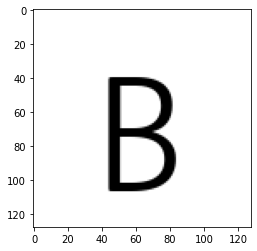

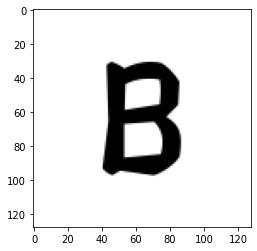

In [13]:
plt.imshow(source[1], cmap='gray')
plt.show()
plt.imshow(target[1], cmap='gray')
plt.show()

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim

def Conv2d(c_in, c_out):
    return nn.Sequential(
        nn.LeakyReLU(0.2),
        nn.Conv2d(c_in, c_out),
        nn.BatchNorm2d(c_out)
    )
def DeConv2d(c_in, c_out):
    return nn.Sequential(
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(c_in, c_out),
        nn.BatchNorm2d(c_out),
        nn.Dropout(0.5),
    )

class En(nn.Module):
    def __init__(self):
        super(En, self).__init__()
        cs = 64

        # in, out, k, s, p
        self.e1 = nn.Sequential(
            nn.Conv2d(1, cs, 4, 2, 1)
        )
        self.e2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.e3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*2, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.e4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*4, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.e6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8)
        )
        self.e7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(cs*8, cs*8, 4, 2, 1),
            # nn.BatchNorm2d(cs*8)
        )

    def forward(self, x):
        d = dict()
        x = self.e1(x)
        d['e1'] = x
        x = self.e2(x)
        d['e2'] = x
        x = self.e3(x)
        d['e3'] = x
        x = self.e4(x)
        d['e4'] = x
        x = self.e5(x)
        d['e5'] = x
        x = self.e6(x)
        d['e6'] = x
        x = self.e7(x)
        d['e7'] = x
        return x, d

        
class De(nn.Module):
    def __init__(self):
        super(De, self).__init__()
        cs = 64

        # 128 = style vector
        self.d1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8+128, cs*8, 3, 1, 1), # e1이랑 합치기위해 유지
            # nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5)
        )
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
            nn.Dropout(0.5),
        )
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*8, 4, 2, 1),
            nn.BatchNorm2d(cs*8),
        )
        self.d5 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*16, cs*4, 4, 2, 1),
            nn.BatchNorm2d(cs*4),
        )
        self.d6 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*8, cs*2, 4, 2, 1),
            nn.BatchNorm2d(cs*2),
        )
        self.d7 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*4, cs, 4, 2, 1),
            nn.BatchNorm2d(cs),
        )
        self.d8 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(cs*2, 1, 4, 2, 1),
        )  

    def forward(self, x, e):
        x = self.d1(x)
        x = torch.cat((x, e['e7']), dim=1)
        x = self.d2(x)
        x = torch.cat((x, e['e6']), dim=1)
        x = self.d3(x)
        x = torch.cat((x, e['e5']), dim=1)
        x = self.d4(x)
        x = torch.cat((x, e['e4']), dim=1)
        x = self.d5(x)
        x = torch.cat((x, e['e3']), dim=1)
        x = self.d6(x)
        x = torch.cat((x, e['e2']), dim=1)
        x = self.d7(x)
        x = torch.cat((x, e['e1']), dim=1)
        x = self.d8(x)

        return x

class Generator(nn.Module):
    def __init__(self, En, De):
        super(Generator, self).__init__()
        self.En = En()
        self.De = De()

    def forward(self, x, vec):
        x, d = self.En(x)

        x = torch.cat((x, vec), dim=1)
        print(x.shape)
        x = self.De(x, d)
        
        return x

In [125]:
generator = Generator(En, De)
x = torch.FloatTensor([source[0]]).reshape((-1,1,128,128)) / 255
style_vector = torch.FloatTensor(np.random.normal(size=(1, 128, 1, 1)))

generator(x, style_vector)

torch.Size([1, 640, 1, 1])
torch.Size([1, 640, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 1024, 1, 1])
torch.Size([1, 512, 2, 2])
torch.Size([1, 1024, 2, 2])
torch.Size([1, 512, 4, 4])
torch.Size([1, 1024, 4, 4])
torch.Size([1, 512, 8, 8])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 128, 32, 32])


tensor([[[[ 0.2877,  1.3804, -0.0285,  ...,  0.5893,  0.1707,  0.9383],
          [-0.6125, -2.2226, -0.6708,  ...,  0.8264, -1.1004, -0.7646],
          [-0.4222,  0.0293,  2.4696,  ...,  0.6781,  0.7411,  2.2657],
          ...,
          [-0.8157, -0.7448, -2.1004,  ...,  1.3501,  1.1647,  0.4522],
          [ 0.0899,  0.1013,  1.0905,  ...,  0.7503,  0.1442,  0.5260],
          [ 0.2984,  0.1080, -0.3932,  ..., -0.2924, -0.9519, -0.6284]]]],
       grad_fn=<SlowConvTranspose2DBackward>)

In [ ]:
x = torch.FloatTensor([[[[1,1,],[1,1]],[[1,1,],[1,1]],[[1,1,],[1,1]],[[1,1,],[1,1]]]])
print(x.shape)
model = nn.Conv2d(4,4,2,1,0)
print(model(x).shape)

In [ ]:
# 실험 1